# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch & PyTorch Lightning in Python

In [1]:
# run this in Google Colab
!pip install pytorch-lightning

  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)


In [2]:
# run this in Google Colab
!nvidia-smi

Wed Sep  1 16:56:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   48C    P2    25W / 156W |   1179MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -qq arff2pandas

In [4]:
!pip install -q -U watermark

In [5]:
# !pip install -qq -U pandas

In [1]:
import os
import time

# use this display function to display DataFrames nicely
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# change theme, color palette, and font_scale
sns.set(style='whitegrid', palette='tab20', font_scale=1.5)

# set default figure size
plt.rcParams['figure.figsize'] = (16, 10)

from sklearn.model_selection import train_test_split
from arff2pandas import a2p
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [2]:
torch.__version__

'1.9.0'

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data



The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N) 
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB) 
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

The dataset is available on my Google Drive. Let's get it:

In [11]:
# ONLY RUN THIS IN COLAB
!gdown --id 1yxICFDJyYnh45gWdX4cxGTAD7ZgKvLGN

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
# RUN THIS ON COLAB to unrar it
!unrar x ECG5000.rar

'unrar' is not recognized as an internal or external command,
operable program or batch file.


NOTE: If on local machine, download the file from [Google Drive link here](https://drive.google.com/file/d/1sYTJMkNhnfQRbzcCpH1QH256zmOjk4HZ/view?usp=sharing), and extract the file and copy into the root directory of this project. You should see a "data" folder with an "ECG5000" folder inside.

The data comes in multiple formats. We'll load the `arff` files into Pandas data frames:

In [6]:
with open(os.path.join('data', 'ECG5000', 'ECG5000_TRAIN.arff')) as f:
    train = a2p.load(f)

with open(os.path.join('data', 'ECG5000', 'ECG5000_TEST.arff')) as f:
    test = a2p.load(f)

We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:

In [7]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [8]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1


We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [9]:
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

Next, we'll rename the last column to `target`, so its easier to reference it:

In [10]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:

In [11]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

Let's plot the results:

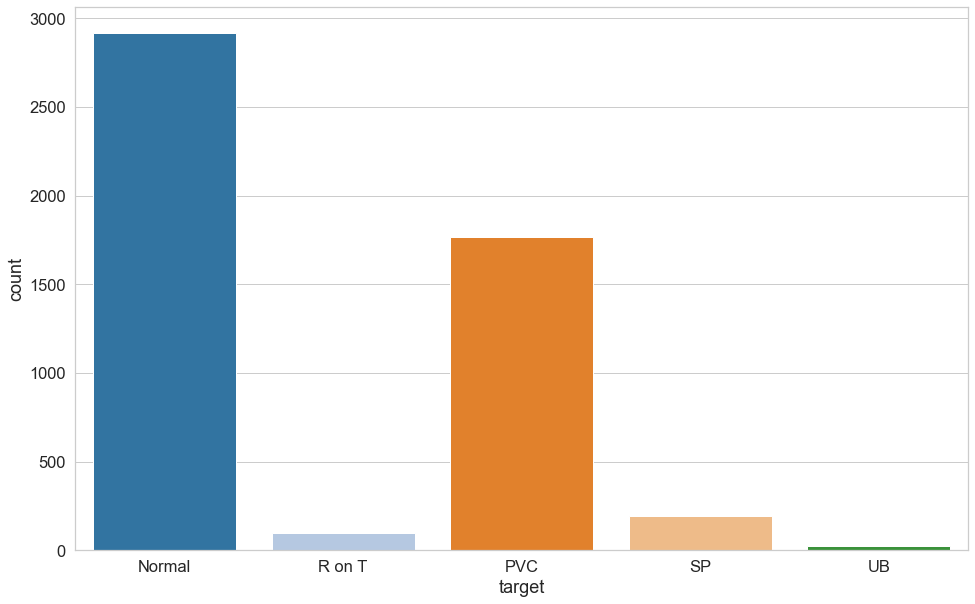

In [12]:
ax = sns.countplot(data=df, x='target')
ax.set_xticklabels(class_names);

The normal class, has by far, the most examples. This is great because we'll use it to train our model, to reconstruct normal class properly (low loss), whereas anomalies would have high reconstruction loss.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [13]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
    )
    ax.set_title(class_name)

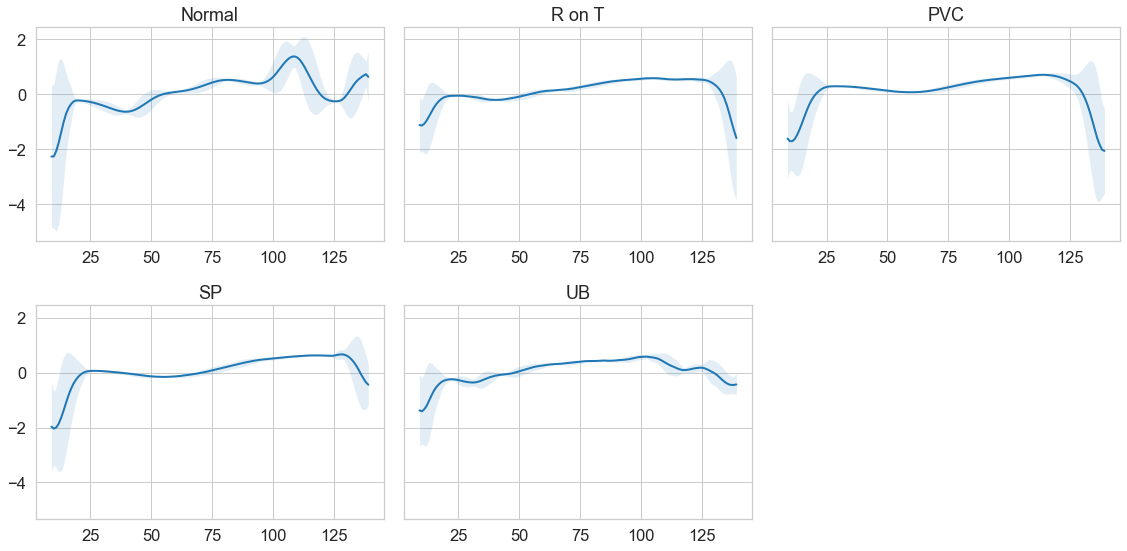

In [14]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(16, 8)
)

for i, c in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == c] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

# delete the unused 6th subplot
fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [15]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

We'll merge all other classes and mark them as anomalies:

In [16]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

We'll split the normal examples into train, validation and test sets:

In [17]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [18]:
class SequenceDataset(Dataset):
    def __init__(self, df):
        self.sequences = df.astype(np.float32).values
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx])
        sequence.unsqueeze_(-1)
        return sequence

In [19]:
train_dataset = SequenceDataset(train_df)
val_dataset = SequenceDataset(val_df)
test_normal_dataset = SequenceDataset(test_df)
test_anomaly_dataset = SequenceDataset(anomaly_df)

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

In [20]:
for x in train_dataset:
    print(x.shape)
    break

torch.Size([140, 1])


We save the sequence length and number of features to use later.

In [21]:
seq_len, n_features = x.shape

In [33]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## LSTM Autoencoder Model Building

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [23]:
embedding_dim = 128
hidden_dim = 2 * embedding_dim

In [24]:
seq_len, n_features

(140, 1)

In [25]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        # reshape and add a dimension at front for batch_size if necessary
        x = x.reshape((-1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((-1, self.n_features, self.embedding_dim))

In [26]:
class Decoder(nn.Module):
    def __init__(self, seq_len, embedding_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.embedding_dim = seq_len, embedding_dim
        self.hidden_dim, self.n_features = 2 * embedding_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=embedding_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=embedding_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        # x = x.repeat(x.shape[0], self.seq_len, self.n_features)
        x = x.repeat_interleave(self.seq_len, dim=1)
        x = x.repeat_interleave(self.n_features, dim=2)
        # x = x.reshape((self.n_features, self.seq_len, self.embedding_dim))
        x = x.reshape((-1, self.seq_len, self.embedding_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((-1, self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [27]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, seq_len, n_features, embedding_dim=128):
        super().__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        output = self.decoder(embedding)
        return output

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x = batch
        x_hat = self(x)
        x_hat = x_hat.reshape(len(batch), self.seq_len, self.n_features)
        # calculate the reconstruction loss by comparing with original input
        loss = self.criterion(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch
        x_hat = self(x)
        x_hat = x_hat.reshape(len(batch), self.seq_len, self.n_features)
        # calculate the reconstruction loss by comparing with original input
        val_loss = self.criterion(x_hat, x)
        # Logging to TensorBoard by default
        self.log("val_loss", val_loss, prog_bar=True, logger=True)
        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [34]:
# test using the model
model = LitAutoEncoder(seq_len, n_features)
print(f"Input shape = {x.shape}")
print(f"Output shape = {model(x).shape}")

Input shape = torch.Size([140, 1])
Output shape = torch.Size([1, 140, 1])


In [35]:
encoder_output = model.encoder(x)
encoder_output.shape

torch.Size([1, 1, 128])

In [36]:
encoder_output.repeat(encoder_output.shape[0], seq_len, n_features).shape

torch.Size([1, 140, 128])

In [37]:
encoder_output.repeat_interleave(seq_len, dim=1).shape

torch.Size([1, 140, 128])

## Training

In [38]:
# Initialize a trainer
# trainer = pl.Trainer(fast_dev_run=True, gpus=1, progress_bar_refresh_rate=20)
trainer = pl.Trainer(gpus=1, max_epochs=3, progress_bar_refresh_rate=20)

# Train the model ⚡
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | encoder   | Encoder | 462 K 
1 | decoder   | Decoder | 527 K 
2 | criterion | MSELoss | 0     
--------------------------------------
990 K     Trainable params
0         Non-trainable params
990 K     Total params
3.962     Total estimated model params size (MB)


Epoch 0:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 80/88 [00:02<00:00, 34.78it/s, loss=0.929, v_num=1, train_loss=0.811]
Validating: 0it [00:00, ?it/s]
Epoch 1:  91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 80/88 [00:02<00:00, 35.46it/s, loss=0.403, v_num=1, train_loss=0.324, val_loss=0.688]
Validating: 0it [00:00, ?it/s]
Epoch 2:  91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 80/88 [00:02<00:00, 35.50it/s, loss=0.335, v_num=1, train_loss=0.301, val_loss=0.343]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:02<00:00, 36.49it/s, loss=0.334, v_num=1, train_loss=0.358, val_loss=0.315]


In [42]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [148]:
model.freeze()

## Saving the model

Let's store the model for later use:

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ROOT_DIR = '/content/drive/MyDrive/Colab Notebooks/time_series_app'
# MODEL_PATH = ROOT_DIR + '/anomaly_detector.h5'
# recurrent_ae.save(MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [ ]:
# !gdown --id 15xp-nV4o2jQ-UtqGmjrGO0Kv8oo42Vqx
# recurrent_ae = keras.models.load_model('anomaly_detector.h5')

Downloading...
From: https://drive.google.com/uc?id=15xp-nV4o2jQ-UtqGmjrGO0Kv8oo42Vqx
To: /content/anomaly_detector.h5
10.3MB [00:00, 39.1MB/s]


## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [80]:
def predict(model, dataset, verbose=0):
    model.freeze()
    criterion = model.criterion
    losses = []
    # batch_size of 1 in this example, so must go through dataset 1 by 1
    with torch.no_grad():
        for x in dataset:
            seq_pred = model(x)
            loss = criterion(seq_pred, x)
            losses.append(loss.item())
    losses = np.asarray(losses)
    if verbose:
        print(f"seq_pred.shape = {seq_pred.shape}")
        print(f"losses.shape = {losses.shape}")
    return losses

In [162]:
def predict(model, dataset, verbose=0):
    model.freeze()
    criterion = model.criterion
    losses = []
    # batch_size of 1 in this example, so must go through dataset 1 by 1
    with torch.no_grad():
        input_sequences = torch.stack([x for x in dataset], axis=0)
        seq_pred = model(input_sequences)
        for pred, input_seq in zip(seq_pred, input_sequences):
            loss = criterion(pred, input_seq)
            losses.append(loss.item())
    losses = np.asarray(losses)
    if verbose:
        print(f"seq_pred.shape = {seq_pred.shape}")
        print(f"losses.shape = {losses.shape}")
    return losses

In [154]:
torch.stack([x for x in train_dataset], axis=0).shape

torch.Size([2481, 140, 1])

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

In [155]:
%%time
losses = predict(model, train_dataset, verbose=1)

seq_pred.shape = torch.Size([2481, 140, 1])
losses.shape = (2481,)
Wall time: 8.11 s


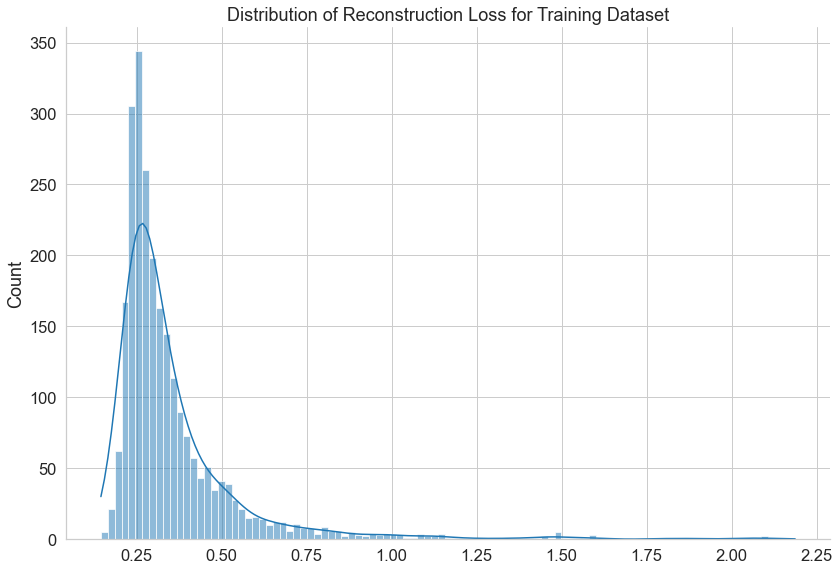

In [156]:
sns.displot(losses, kde=True, height=8, aspect=1.5)
plt.title('Distribution of Reconstruction Loss for Training Dataset')
plt.show()

In [157]:
THRESHOLD = 1.0

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal heartbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

seq_pred.shape = torch.Size([145, 140, 1])
losses.shape = (145,)
Wall time: 840 ms


Text(0.5, 1.0, 'Distribution of Reconstruction Loss for Testing Dataset for Normal Heartbeats')

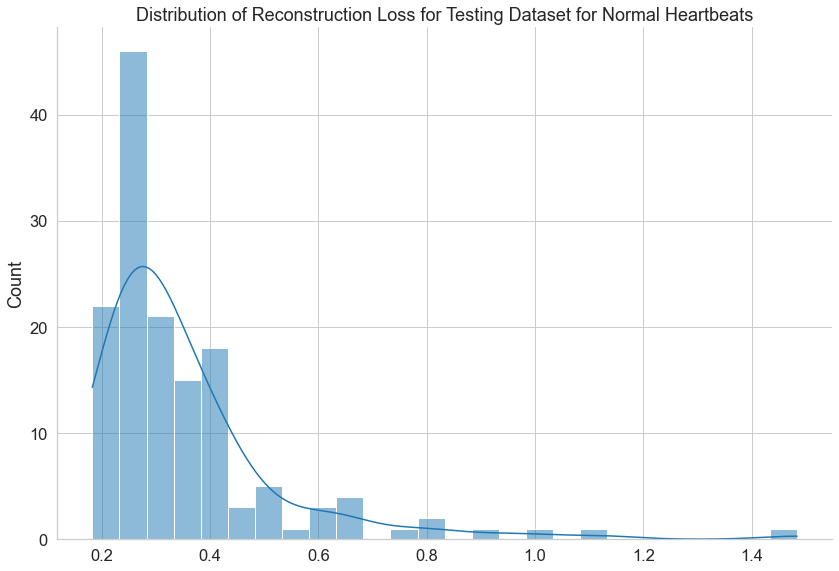

In [163]:
%%time
pred_losses = predict(model, test_normal_dataset, verbose=1)
sns.displot(pred_losses, kde=True, height=8, aspect=1.5)
plt.title('Distribution of Reconstruction Loss for Testing Dataset for Normal Heartbeats');

We'll count the correct predictions:

In [164]:
def pred_results(pred_losses, data, label_type='normal'):
    assert label_type in ('normal', 'anomaly')
    if label_type == 'normal':
        correct = np.sum(np.where(pred_losses <= THRESHOLD, 1, 0))
    else:
        correct = np.sum(np.where(pred_losses > THRESHOLD, 1, 0))
    pct = np.around(correct / len(data) * 100, 2)
    print(f'Correct {label_type} predictions: {correct}/{len(data)} ({pct}%)')

In [165]:
pred_results(pred_losses, test_normal_dataset)

Correct normal predictions: 143/145 (98.62%)


### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [166]:
len(test_normal_dataset), len(test_anomaly_dataset)

(145, 2081)

In [167]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
# anomaly_dataset = test_anomaly_dataset

Now we can take the predictions of our model for the subset of anomalies:

seq_pred.shape = torch.Size([145, 140, 1])
losses.shape = (145,)
Wall time: 787 ms


Text(0.5, 1.0, 'Distribution of Reconstruction Loss for Testing Dataset for Anomalous Heartbeats')

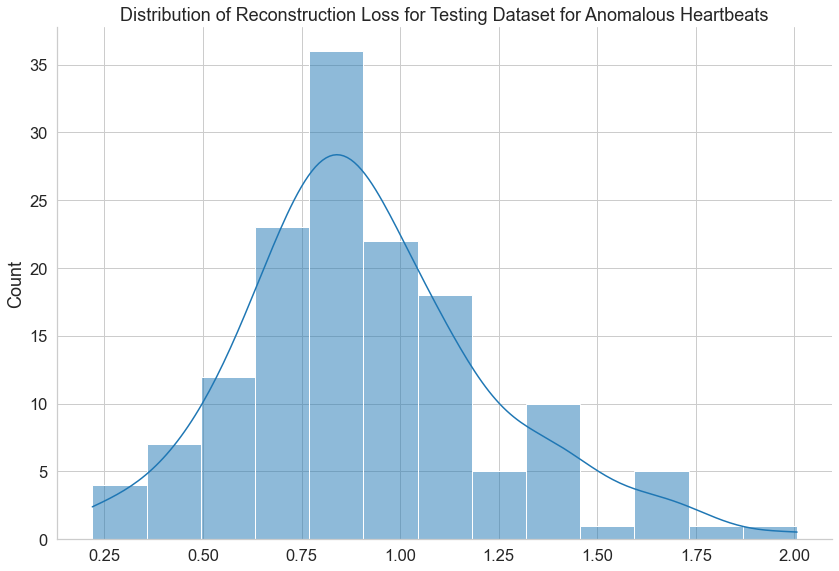

In [168]:
%%time
pred_anomaly_losses = predict(model, anomaly_dataset, verbose=1)
sns.displot(pred_anomaly_losses, kde=True, height=8, aspect=1.5)
plt.title('Distribution of Reconstruction Loss for Testing Dataset for Anomalous Heartbeats');

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [169]:
pred_results(pred_anomaly_losses, anomaly_dataset, label_type='anomaly')

Correct anomaly predictions: 48/145 (33.1%)


We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [ ]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, tf.expand_dims(data, axis=0))

    ax.plot(data, label="true")
    ax.plot(predictions[0], label="reconstructed")
    ax.set_title(f"{title}\n(loss: {pred_losses[0]:.2f})")
    ax.legend()

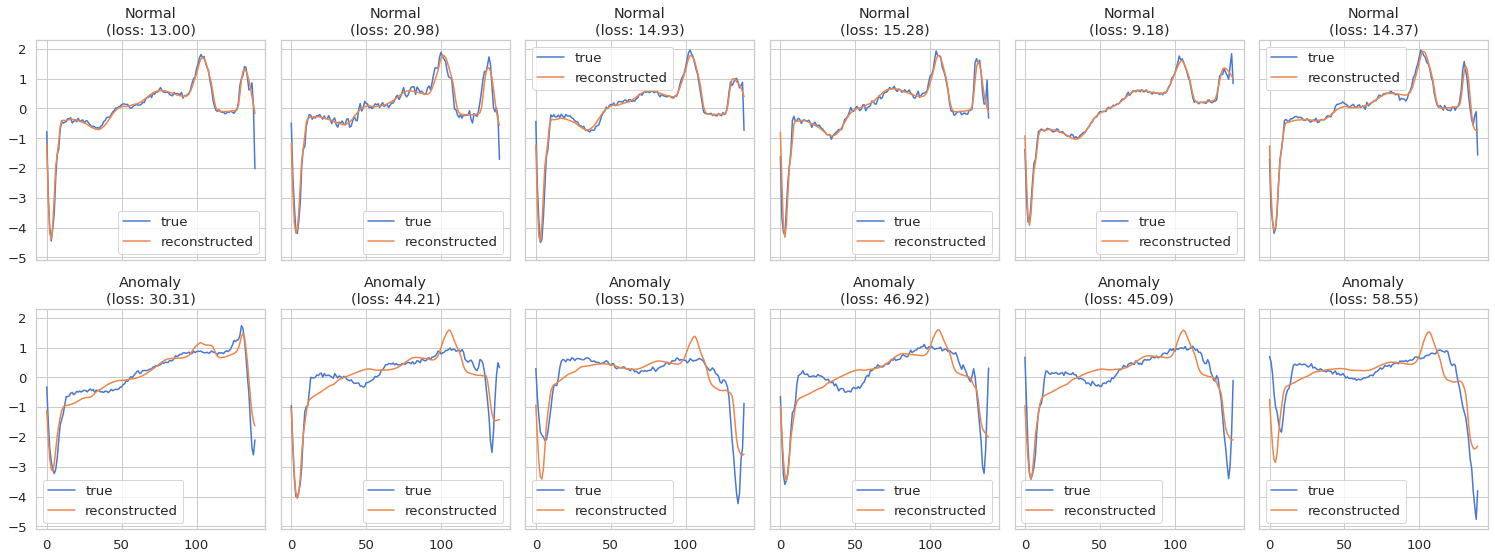

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(21, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, recurrent_ae, title="Normal", ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, recurrent_ae, title="Anomaly", ax=axs[1, i])

fig.tight_layout();

## References

- [Venelin Valkov - Time Series Anomaly Detection](https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/06.time-series-anomaly-detection-ecg.ipynb)